In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import networkx as nx
import seaborn as sns

from joblib import Parallel, delayed

from IPython.display import clear_output

In [3]:
df = pd.read_pickle('./data/j1c-features-cleaned.pkl', compression='gzip')

In [4]:
graph_array = np.load('./data/vectorized_graphs.npz')['arr_0']

In [5]:
df.shape

(12005167, 13)

In [6]:
df.head()

,num_edges,is_planar,total_triangles,triangle_ratio,avg_shortest_path_length,global_clustering_coefficient,avg_clustering_coefficient,square_clustering,density,node_connectivity,global_efficiency,local_efficiency,modularity
1,1,True,0,0.0,1.000000,0.0,0.0,0.0,0.022222,0,0.022222,0.0,0.0
2,2,True,0,0.0,1.333333,0.0,0.0,0.0,0.044444,0,0.055556,0.0,0.0
3,3,True,0,0.0,1.500000,0.0,0.0,0.0,0.066667,0,0.100000,0.0,0.0
4,4,True,0,0.0,1.600000,0.0,0.0,0.0,0.088889,0,0.155556,0.0,0.0
5,5,True,0,0.0,1.666667,0.0,0.0,0.0,0.111111,0,0.222222,0.0,0.0


In [7]:
ORDERING = dict(
    # num_edges = "# Edges",
    density="Density",
    # total_triangles = '# Triangles',
    triangle_ratio="Triangle Ratio",
    # is_planar="Is Planar Graph?",
    avg_shortest_path_length="Avg Shortest Path",
    global_clustering_coefficient="Global Clustering",
    avg_clustering_coefficient="Avg Clustering",
    # square_clustering="Square Clustering",
    global_efficiency="Global Efficiency",
    local_efficiency="Local Efficiency",
    # degree_assortativity = "Degree Assortativity",
    # diameter = 'Diameter',
    node_connectivity="Node Connectivity",
    modularity="Modularity",
)

In [8]:
ORDERING = dict(
    # num_edges = "# Edges",
    #density="Density",
    # total_triangles = '# Triangles',
    #triangle_ratio="Triangle Ratio",
    # is_planar="Is Planar Graph?",
    avg_shortest_path_length="Avg Shortest Path",
    global_clustering_coefficient="Global Clustering",
    avg_clustering_coefficient="Avg Clustering",
    # square_clustering="Square Clustering",
    global_efficiency="Global Efficiency",
    local_efficiency="Local Efficiency",
    # degree_assortativity = "Degree Assortativity",
    # diameter = 'Diameter',
    #node_connectivity="Node Connectivity",
    modularity="Modularity",
)

In [13]:
def hexbin(
    df,
    df2,
    df3, 
    ordering,
    x_col="modularity",
    gridsize=40,
    cmap="Blues",
    bins="log",
    title=None,
    ax1_title=None,
    ax2_title=None,
    ax3_title=None,
    savefig=None,
):
    with sns.plotting_context('talk'):
        xlabel = ordering[x_col]
        ordering = {key:val for key, val in ordering.items() if key != x_col}

        ncols = 3
        nrows = len(ordering)
        figsize = (4*ncols, 3*nrows)

        fig, ax = plt.subplots(
            ncols=ncols, 
            nrows=nrows, 
            figsize=figsize, 
            sharex=True, 
            sharey='row',
            #constrained_layout=True
        )

        for idx, (col, y_label) in enumerate(ordering.items()):
            ax[idx, 0].hexbin(
                x=df[x_col], y=df[col], cmap=cmap, gridsize=gridsize, bins=bins, mincnt=1
            )
            sns.despine(ax=ax[idx, 0])
            #ax[idx, 0].set_xlabel('Modularity')
            ax[idx, 0].set_ylabel(y_label)

            ax[idx, 1].hexbin(
                x=df2[x_col], y=df2[col], cmap=cmap, gridsize=gridsize, bins=bins, mincnt=1
            )
            sns.despine(ax=ax[idx, 1])
            
            ax[idx, 2].hexbin(
                x=df3[x_col], y=df3[col], cmap=cmap, gridsize=gridsize, bins=bins, mincnt=1
            )
            sns.despine(ax=ax[idx, 2])
            #ax[idx].set_xlabel('Modularity', fontsize=20)
            #ax[idx].set_ylabel(y_label, fontsize=20)

        for i in range(3):
            ax[-1, i].set_xlabel(xlabel)

#         if len(ordering) != (ncols * nrows):
#             for i in range(1, len(ax) - len(ordering) + 1):
#                 fig.delaxes(ax[-i])

        fig.tight_layout()

        if title is not None:
            fig.suptitle(title, y=1.02, fontsize=30)
        
        if ax1_title is not None:
            ax[0, 0].set_title(ax1_title)
        if ax2_title is not None:
            ax[0, 1].set_title(ax2_title)
        if ax3_title is not None:
            ax[0, 2].set_title(ax3_title)

        #ax[0, 1].set_title("Graphs with 20 +/- 3 Edges")
        #ax[0, 1].set_title(f"Graphs with {}")

        if savefig is not None:
            fig.savefig(f"{savefig}.pdf", dpi=300, bbox_inches='tight')
            fig.savefig(f"{savefig}.png", dpi=300, bbox_inches='tight')

In [14]:
np.unique(df.num_edges)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

Making figure 20
Making figure 21
Making figure 22


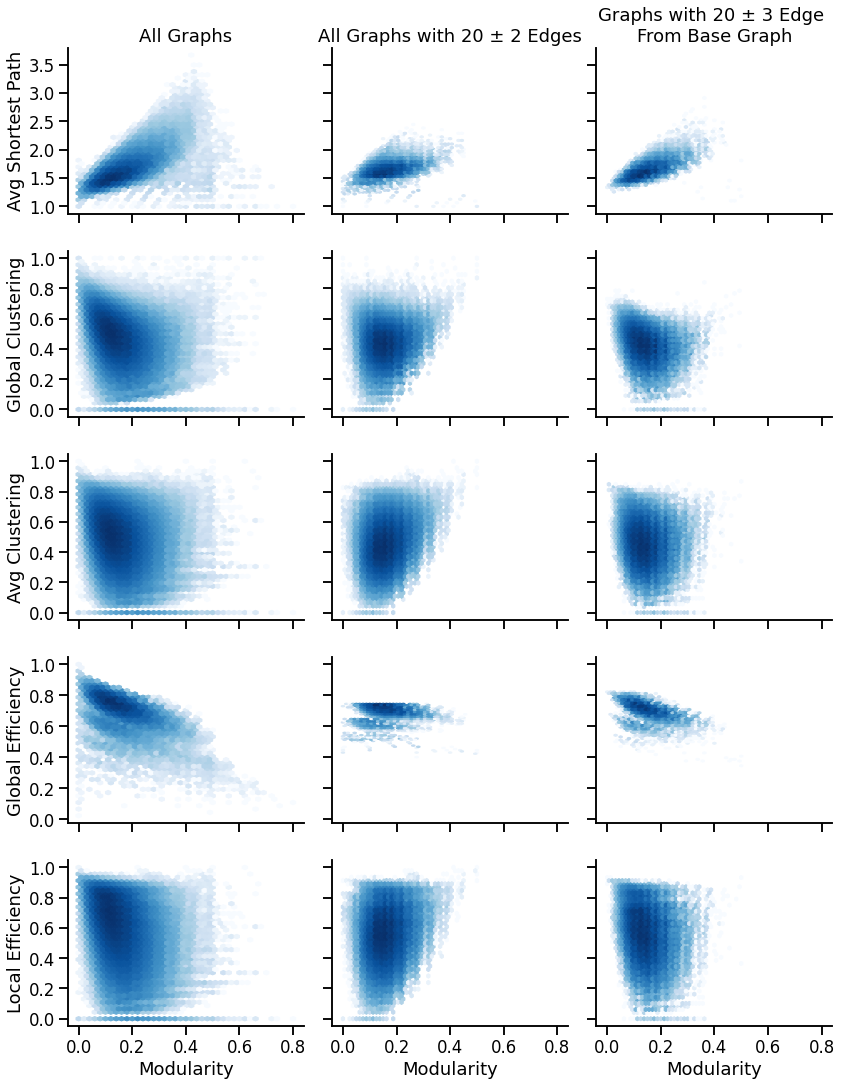

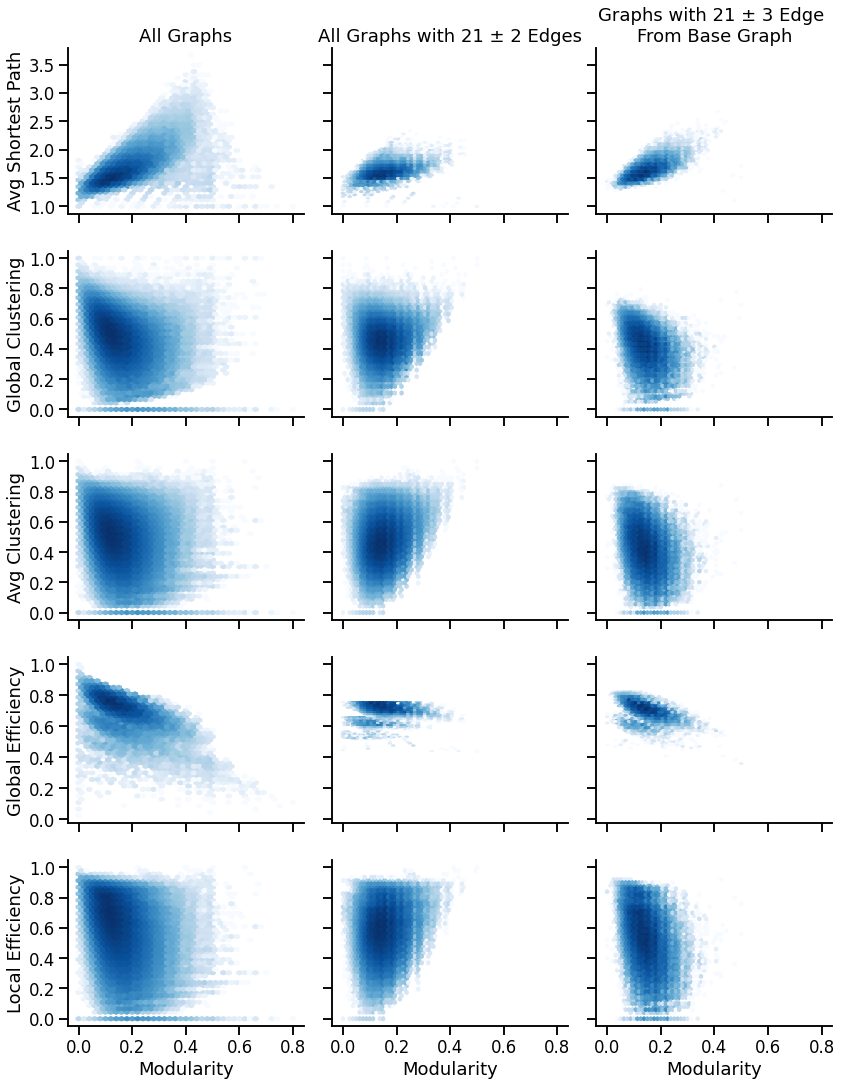

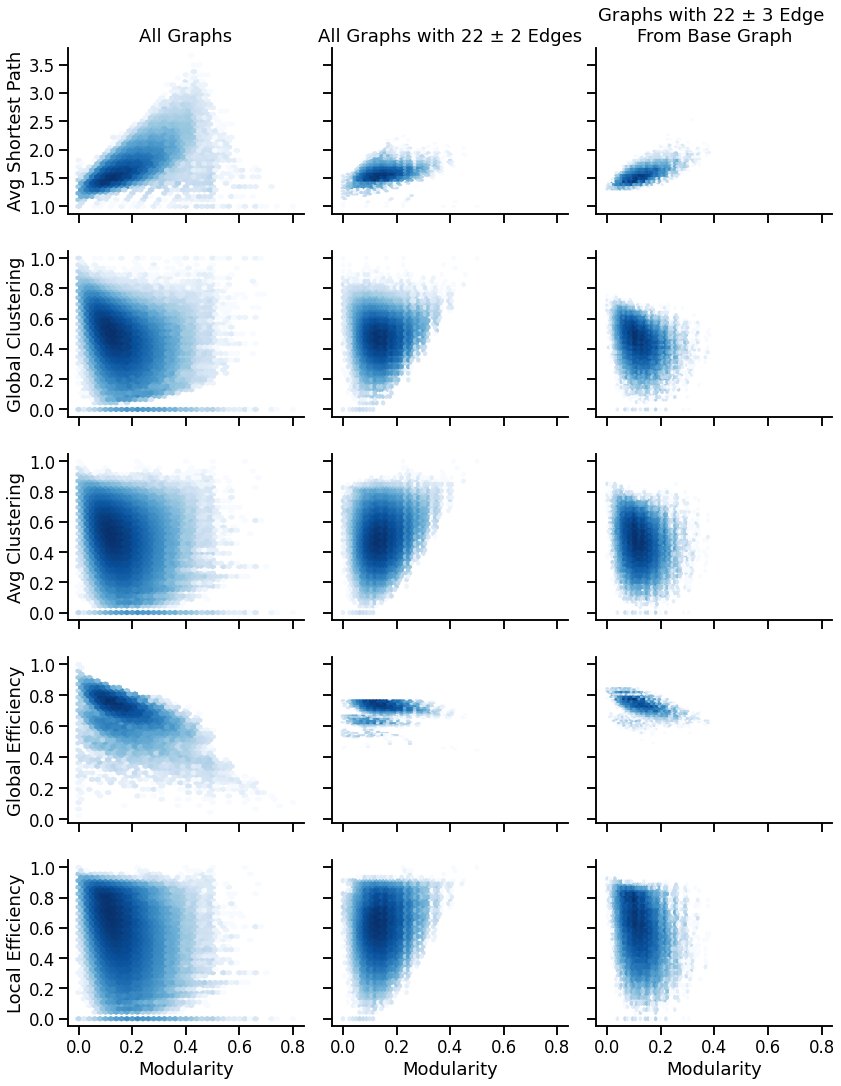

In [15]:
densities = np.unique(df.density)
threshold = 2

for idx, num_edge in enumerate(np.unique(df.num_edges)):
    if (idx < 19) or (idx > 21):
        continue
    np.random.seed(1)
    tmp = df[df.num_edges == num_edge]
    
    random_idx = np.random.choice(tmp.index)
    norms = np.linalg.norm(graph_array - graph_array[random_idx], axis=1)
    
    mask = np.arange(1, graph_array.shape[0]+1)[norms < 3]
    tmp = df.loc[mask]
    
    tmp2 = df[df.density.isin(densities[idx-threshold:idx+threshold+1])]

    print(f"Making figure {num_edge}")
    hexbin(
        df,
        tmp2,
        tmp, 
        ORDERING, 
        #title=f"Base Graph Edges={num_edge}, Threshold=3, n={tmp.shape[0]}",
        ax1_title="All Graphs",
        ax2_title=f"All Graphs with {num_edge} ± 2 Edges",
        ax3_title=f"Graphs with {num_edge} ± 3 Edge \nFrom Base Graph",
        savefig=f"./density_num_edge_{num_edge}"
    )
    #plt.close()

## Use density as measure

In [13]:
densities = np.unique(df.density)
threshold = 2

for idx, den in enumerate(densities):
    if (idx < 9) or (idx > 35):
        continue
    
    tmp = df[df.density.isin(densities[idx-threshold:idx+threshold+1])]

    print(f"Making figure {den}")
    hexbin(
        df,
        tmp, 
        ORDERING, 
        #title=f"Base Graph Edges={int(den * 45)}, Threshold=2, n={tmp.shape[0]}", 
        ax1_title="All Graphs",
        ax2_title=f"Graphs with {int(den * 45)} +/- {threshold} Edges",
        savefig=f"./figures/density_plot_{int(den * 45)}"
    )
    plt.close()

Making figure 0.2222222238779068
Making figure 0.24444444477558136
Making figure 0.2666666805744171
Making figure 0.2888889014720917
Making figure 0.31111112236976624
Making figure 0.3333333432674408
Making figure 0.35555556416511536
Making figure 0.3777777850627899
Making figure 0.4000000059604645
Making figure 0.42222222685813904
Making figure 0.4444444477558136
Making figure 0.46666666865348816
Making figure 0.4888888895511627
Making figure 0.5111111402511597
Making figure 0.5333333611488342
Making figure 0.5555555820465088
Making figure 0.5777778029441833
Making figure 0.6000000238418579
Making figure 0.6222222447395325
Making figure 0.644444465637207
Making figure 0.6666666865348816
Making figure 0.6888889074325562
Making figure 0.7111111283302307
Making figure 0.7333333492279053
Making figure 0.7555555701255798
Making figure 0.7777777910232544
Making figure 0.800000011920929


## Try horizontal layout

In [41]:
def hexbin(
    df,
    df2,
    df3, 
    ordering,
    x_col="modularity",
    gridsize=40,
    cmap="Blues",
    bins="log",
    title=None,
    ax1_title=None,
    ax2_title=None,
    ax3_title=None,
    savefig=None,
):
    with sns.plotting_context('talk'):
        xlabel = ordering[x_col]
        ordering = {key:val for key, val in ordering.items() if key != x_col}

        nrows = 3
        ncols = len(ordering)
        figsize = (3.5*ncols, 3*nrows)

        fig, ax = plt.subplots(
            ncols=ncols, 
            nrows=nrows, 
            figsize=figsize, 
            sharex='col', 
            sharey='col',
            #constrained_layout=True
        )

        for idx, (col, y_label) in enumerate(ordering.items()):
            ax[0, idx].hexbin(
                x=df[x_col], y=df[col], cmap=cmap, gridsize=gridsize, bins=bins, mincnt=1
            )
            sns.despine(ax=ax[0, idx])
            #ax[idx, 0].set_xlabel('Modularity')

            ax[0, idx].set_title(y_label)

            ax[1, idx].hexbin(
                x=df2[x_col], y=df2[col], cmap=cmap, gridsize=gridsize, bins=bins, mincnt=1
            )
            sns.despine(ax=ax[1, idx])
            
            ax[2, idx].hexbin(
                x=df3[x_col], y=df3[col], cmap=cmap, gridsize=gridsize, bins=bins, mincnt=1
            )
            sns.despine(ax=ax[2, idx])
            #ax[idx].set_xlabel('Modularity', fontsize=20)
            #ax[idx].set_ylabel(y_label, fontsize=20)
            
            

        for i in range(5):
            ax[-1, i].set_xlabel(xlabel)

#         if len(ordering) != (ncols * nrows):
#             for i in range(1, len(ax) - len(ordering) + 1):
#                 fig.delaxes(ax[-i])

        fig.tight_layout()

        if title is not None:
            fig.suptitle(title, y=1.02, fontsize=30)
        
        if ax1_title is not None:
            ax[0, 0].set_ylabel(ax1_title)
        if ax2_title is not None:
            ax[1, 0].set_ylabel(ax2_title)
        if ax3_title is not None:
            ax[2, 0].set_ylabel(ax3_title)

        #ax[0, 1].set_title("Graphs with 20 +/- 3 Edges")
        #ax[0, 1].set_title(f"Graphs with {}")

        if savefig is not None:
            fig.savefig(f"{savefig}.pdf", dpi=300, bbox_inches='tight')
            fig.savefig(f"{savefig}.png", dpi=300, bbox_inches='tight')

In [ ]:
densities = np.unique(df.density)
threshold = 2

for idx, num_edge in enumerate(np.unique(df.num_edges)):
    if (idx <= 19) or (idx >= 21):
        continue
    np.random.seed(1)
    tmp = df[df.num_edges == num_edge]
    
    random_idx = np.random.choice(tmp.index)
    norms = np.linalg.norm(graph_array - graph_array[random_idx], axis=1)
    
    mask = np.arange(1, graph_array.shape[0]+1)[norms < 3]
    tmp = df.loc[mask]
    
    tmp2 = df[df.density.isin(densities[idx-threshold:idx+threshold+1])]

    print(f"Making figure {num_edge}")
    hexbin(
        df,
        tmp2,
        tmp, 
        ORDERING, 
        #title=f"Base Graph Edges={num_edge}, Threshold=3, n={tmp.shape[0]}",
        ax1_title="All Graphs",
        ax2_title=f"All Graphs with \n{num_edge} ± 2 Edges",
        ax3_title=f"Graphs with \n{num_edge} ± 3 Edge \nFrom Base Graph",
        savefig=f"./final/density_num_edge_{num_edge}_row"
    )
    #plt.close()

Making figure 21
